# Wolf and Chickens Game

Group formed by Gonzalo Marcos, Ali Ezzeddine and Isabel Alessandrini

This exercise aims to simulate the different dynamics involved in the interactions between a wolf, chickens and the food present in their environment. The different epucks of the simulation will represent the animals and each will have a series of behaviours and routines that will determine how and when they look for food, chase and run from eachother, and rest from their routine.

First, we will start loading the scene `$NameScene` provided along with this code, and we will start the simulator software.

In [1]:
from simulator_interface import open_session, close_session
simulator, epuck1, epuck2, epuck3 = open_session(n_epucks=3)

We will also assign which role each epuck will have in the simulation.

In [2]:
epuck1.species = "chicken"
epuck2.species = "chicken"
epuck3.species = "wolf"

Next we will start defining the different behaviours and routines that the chickens and wolf will have. The first one, obstacle avoidance, will be shared by all as they will want to avoid colliding with the different obstacles present in the environment.

In [3]:
def obstacle_avoidance(robot):
    left, right = robot.prox_activations(tracked_objects=["20cm", "Tree"]) # If more obstacles are added, they will have to be identified here.
 
    return 1 - right, 1 - left

The chickens want to obtain food from the environment while simultaneously avoid the wolf to not get eaten. We will represent the food with a series of spheres that will appear throughout the environment. In order to generate them, we will run the following code:

In [4]:
simulator.start_sphere_apparition(period=15, min_pos=[-1, -1, 1], max_pos=[3, 3, 2]) # The min_pos and max_pos arguments can be modified to restrict where the food will appear

Routine sphere_apparition started
Routine eating started


Now that we have food, we will define the behaviours that will allow the chickens to interact with it. We will start with the hunger, a routine that will condition if the chicken wants to look for food. When the chicken is full, they are sated and walk slowly. Once they have digested the food, they will become more desperate and will run faster.

In [5]:
def hunger(robot): 
    if robot.has_eaten():
        robot.hunger_level = 0  # if the chicken has eaten a sphere, it is no longer hungry and moves slower
        robot.max_speed = 2
    else:
        robot.hunger_level += 0.01  # otherwise (nothing eaten), it will get increasingly hungrier
    
    if robot.hunger_level > 0.7:
        robot.max_speed = 4 # When the chicken gets hungry enough, they start running faster

    robot.hunger_level = min(1., max(robot.hunger_level, 0.)) # We bound the hunger level between 0 and 1

With the previous rutine defined, we can now implement a food chasing behaviour that will be influenced by how hungry the chicken is.

In [6]:
def food_chasing(robot):
    left, right = robot.prox_activations(tracked_objects=["Sphere"])

    return right, left, robot.hunger_level

The chickens can now avoid obstacles, feel hunger and search for food if they are huhgry enough, but we still have to make them fear the wolf and run away from it, so we will implement the wolf avoidance behaviour.

In [7]:
def wolf_avoidance(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none") # Retrieve the species attributes of the sensed epucks

    left_activation = left if left_species == "wolf" else 0
    right_activation = right if right_species == "wolf" else 0  # We avoid the epuck sensed if it's a wolf

    return left_activation, right_activation

We will add a final behaviour to the chickens to make them smarter. When they are not hungry, they will try to hide in their houses (cups) so they can avoid the wolf instead of running around. Once they get hungry enough, they will no longer want to hide as they will have to risk going outside for food.

In [8]:
def hiding(robot):
    left, right = robot.prox_activations(tracked_objects=["Cup"])

    return right, left, 1 - robot.hunger_level # The less hungry, the more the chicken priorizes hiding themselves

Once the chicken behaviours are defined, we will record the internal variables of the chickens in order to plot them later.

In [9]:
def chicken_log(robot):
    # Retrieve the values of the speed and hunger:
    robot.add_log("speed", robot.max_speed)
    robot.add_log("hunger", robot.hunger_level)

Now we begin with programming the behaviors and rootines of the wolf. First we begin with the chicken hunting behavior. This behavior will be controlled by an internal state of the wolf which is his hunger level. We will first define this rootine in the cell below. 

In [10]:
def wolf_hunger(robot):
    left, right = robot.prox_activations(tracked_objects=["ePuck"])
    distance = (left + right)/2 
    if distance > 0.8: 
        robot.hunger_level == 0 # if the robot has eaten a chicken, decrease its hunger level to 0
    else:
        robot.hunger_level += 0.2  # otherwise (nothing eaten), increase the hunger level by 0.2
    # The line below bounds the value of the hunger level between 0 and 1
    robot.hunger_level = min(1., max(robot.hunger_level, 0.))

In [11]:
def chicken_hunting(robot):
    left, right = robot.prox_activations(tracked_objects=["ePuck"])
    left_wheel = right
    right_wheel = left
    
    return left_wheel, right_wheel, robot.hunger_level * robot.energy_level 

When the wolf begins hunting for chickens, the behavior will be controlled by an internal state which we will call energy level. This energy level decreases over a certain period of time. It start with 1 and decreases by 0.1. 

In [12]:
def energy_level(robot):
    left, right = robot.prox_activations(tracked_objects=["ePuck"])
    if left or right > 0:
        robot.energy_level -= 0.2
    else: robot.energy_level = 1
        
    robot.energy_level = min(1., max(robot.energy_level, 0.))
    

Below is the code to implement a fear of the farmer (base of the chicken) behavior to the wolf. This behavior makes sure that the wolf stays away from the farmer because he is armed and dangerous. The behavior has a higher weight than the hunting behavior. 

In [13]:
def fear_farmer(robot):
    left, right = robot.prox_activations(tracked_objects=["Cup"])
    left_wheel = left
    right_wheel = right
    return left_wheel, right_wheel

Once we have defined all the behaviours of the chickens and the wolf, we will assign them and let them interact with eachother.

In [14]:
for e in simulator.robots:
    e.detach_all_behaviors()
    e.stop()
    e.attach_behavior(obstacle_avoidance, freq=10) # All will use obstacle avoidance

# We initialize internal variables
epuck1.max_speed = 4 # Chicken are slower than the wolf
epuck2.max_speed = 4 
epuck3.max_speed = 7

epuck1.hunger_level = 1 # The chickens will start the simulation hungry
epuck2.hunger_level = 1
epuck3.hunger_level = 1

epuck3.energy_level = 1 # The wolf starts the simulation well rested

# Attaching behaviours and routines for the chickens
epuck1.attach_routine(hunger, freq=1)
epuck2.attach_routine(hunger, freq=1)
epuck1.attach_routine(chicken_log, freq=1)
epuck2.attach_routine(chicken_log, freq=1)
epuck1.attach_behavior(food_chasing, freq=10)
epuck2.attach_behavior(food_chasing, freq=10)
epuck1.attach_behavior(wolf_avoidance, freq=10)
epuck2.attach_behavior(wolf_avoidance, freq=10)
epuck1.attach_behavior(hiding, freq=10)
epuck2.attach_behavior(hiding, freq=10)

# Attaching behaviours and routines for the wolf
epuck3.attach_routine(wolf_hunger, freq=1)
epuck3.attach_behavior(chicken_hunting, freq=10)
epuck3.attach_behavior(fear_farmer, freq=10)

# Begin the simulation
for e in simulator.robots:
    e.start_all_routines()
    e.start_all_behaviors()

Routine hunger started
Routine chicken_log started
Behavior obstacle_avoidance started
Behavior food_chasing started
Behavior wolf_avoidance started
Behavior hiding started
Routine hunger started
Routine chicken_log started
Behavior obstacle_avoidance started
Behavior food_chasing started
Behavior wolf_avoidance started
Behavior hiding started
Routine wolf_hunger started
Behavior obstacle_avoidance started
Behavior chicken_hunting started
Behavior fear_farmer started


Now that the simulation is running, we can plot the internal variables of the wolf and chickens. The following code will plot the hunger level over time of the chickens.

Text(0.5, 1.0, 'Plot of hunger level against time')

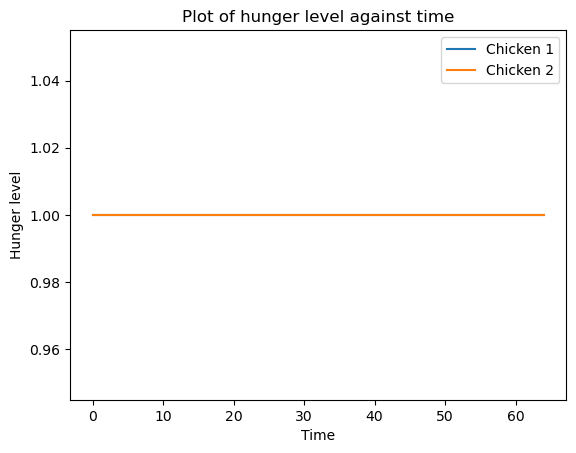

In [18]:
%matplotlib inline

# Plot the hunger levels recorded by the chickens
plot(epuck1.get_log("hunger"))
plot(epuck2.get_log("hunger"))
legend(["Chicken 1", "Chicken 2"])

xlabel("Time")
ylabel("Hunger level")
title("Plot of hunger level against time")

Next we will plot the speed of the chickens over time.

Text(0.5, 1.0, 'Plot of speed against time')

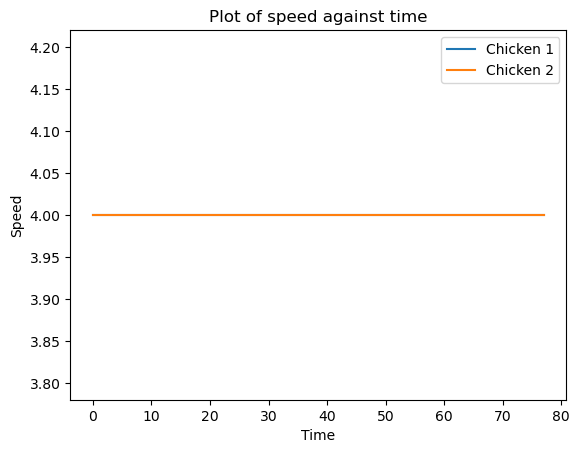

In [20]:
%matplotlib inline

# Plot the speed recorded by the chickens
plot(epuck1.get_log("speed"))
plot(epuck2.get_log("speed"))
legend(["Chicken 1", "Chicken 2"])

xlabel("Time")
ylabel("Speed")
title("Plot of speed against time")

To finish the simulation, execute the following line:

In [ ]:
close_session(simulator)